_This project was developed independently as part of Code Institute’s Predictive Analytics Project. Any datasets or templates used are openly provided by the course or via public sources like Kaggle. All commentary and code logic are my own._

# Notebook 04: Price Analysis

## Objective

- This notebook dives into exploratory data analysis (EDA) focused specifically on the **Sale Price** of properties.  
- We'll analyze patterns, transformations, and outliers — and extract actionable insights to guide model building.

## Change Working Directory
- Since it is expected that you would keep the notebooks in a subfolder, you will need to switch the working directory when you run the notebook in the editor.
- The working directory must be changed from its current folder to its parent folder.
- We wish to change the current directory's parent to the new current directory.
- Verify the updated current directory.

In [30]:
# Smart Working Directory Setup
import os
project_root = '/workspaces/heritage_housing'
if os.getcwd() != project_root:
    try:
        os.chdir(project_root)
        print(f"[INFO] Changed working directory to project root: {os.getcwd()}")
    except FileNotFoundError:
        raise FileNotFoundError(f"[ERROR] Project root '{project_root}' not found!")

## Plot Saving Directory

In [31]:
import os
os.makedirs("outputs/visuals", exist_ok=True)

### Load Libraries
- Load libraries
- Load cleaned data from /data/processed/df_cleaned.csv

In [32]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# Load the Cleaned Data
df = pd.read_csv("data/processed/df_cleaned.csv")

# Review column names
df.columns


Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish',
       'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage',
       'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice'],
      dtype='object')

## Sale Price Distribution

In this section, we examine the distribution of the target variable — `SalePrice`. This will help us understand whether the data is skewed, if log transformation is needed, and whether any outliers are visibly affecting the distribution.

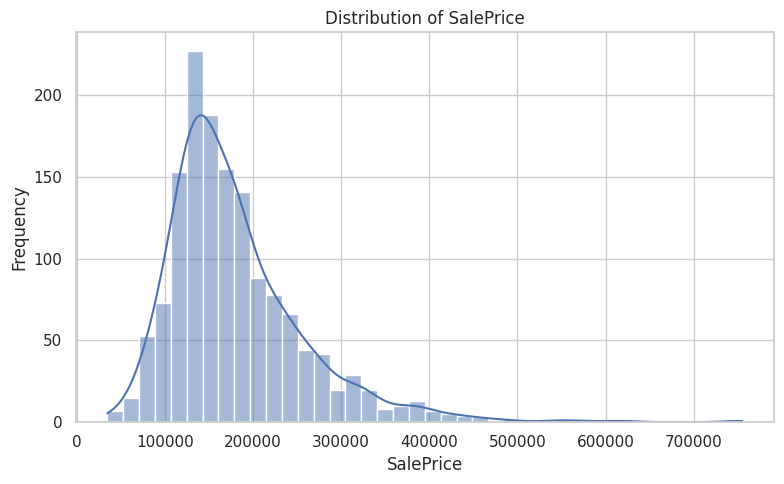

In [33]:
# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['SalePrice'], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Observations:
- The distribution of `saleprice` is right-skewed.
- This skewness may affect model performance due to the violation of linear model assumptions.
- A log transformation will likely help normalize the target.

## Skewness & Kurtosis Analysis

Before applying transformations, we quantify how skewed and peaked the distribution is using statistical metrics.

In [34]:
from scipy.stats import skew, kurtosis

price = df['SalePrice']
print(f"Skewness: {skew(price):.2f}")
print(f"Kurtosis: {kurtosis(price):.2f}")

Skewness: 1.88
Kurtosis: 6.51


### Log-Transformed Target

### Why Apply Log Transformation?
The target variable `SalePrice` is right-skewed, violating assumptions of normality required by many regression models. Applying a log transformation (log1p) helps:
- Normalize the distribution
- Reduce the influence of extreme outliers
- Improve model accuracy

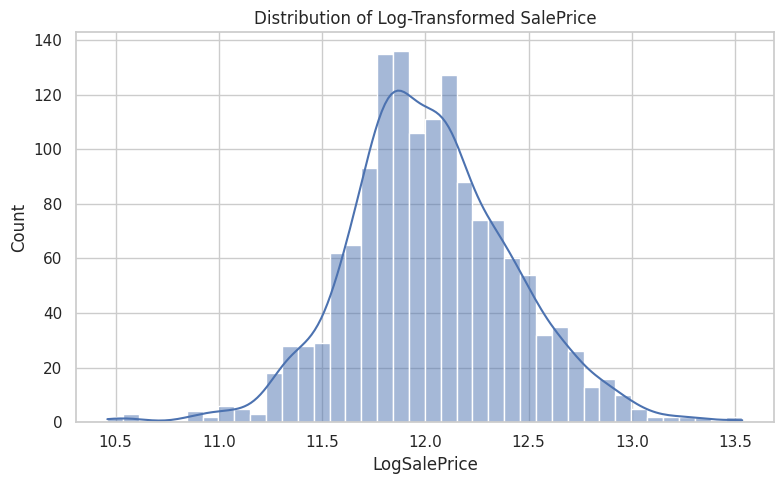

New Skewness: 0.12
New Kurtosis: 0.80


In [35]:
df['LogSalePrice'] = np.log1p(df['SalePrice'])

# Plot new distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['LogSalePrice'], kde=True, bins=40)
plt.title("Distribution of Log-Transformed SalePrice")
plt.xlabel("LogSalePrice")
plt.tight_layout()
plt.show()

# Re-check skewness
print(f"New Skewness: {skew(df['LogSalePrice']):.2f}")
print(f"New Kurtosis: {kurtosis(df['LogSalePrice']):.2f}")

### Updated Skewness Analysis (After Log Transformation)

The log-transformed distribution of `saleprice` is significantly more symmetrical compared to the original. The KDE curve aligns well with a normal distribution shape, indicating:
- **Reduced skewness** — the long right tail is now compressed.
- **Improved model readiness** — this transformation will support better assumptions for linear models.
- Outliers are still visible but now less influential in magnitude.

We will use `LogSalePrice` as the target for further analysis and modeling.

## Correlation Analysis

To identify features that have the strongest relationship with house prices, we'll compute Pearson correlation coefficients between all numerical variables and `LogSalePrice`.

This will help in:
- Selecting features for modeling
- Prioritizing further investigation in the next steps

Top 20 Correlated Features with LogSalePrice:
LogSalePrice    1.000000
SalePrice       0.948374
OverallQual     0.817185
GrLivArea       0.700927
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
YearBuilt       0.586570
YearRemodAdd    0.565608
MasVnrArea      0.426776
BsmtFinSF1      0.372023
GarageYrBlt     0.349013
LotFrontage     0.335292
OpenPorchSF     0.321053
2ndFlrSF        0.311887
LotArea         0.257320
BsmtUnfSF       0.221985
BedroomAbvGr    0.123774
OverallCond     0.036868
Name: LogSalePrice, dtype: float64


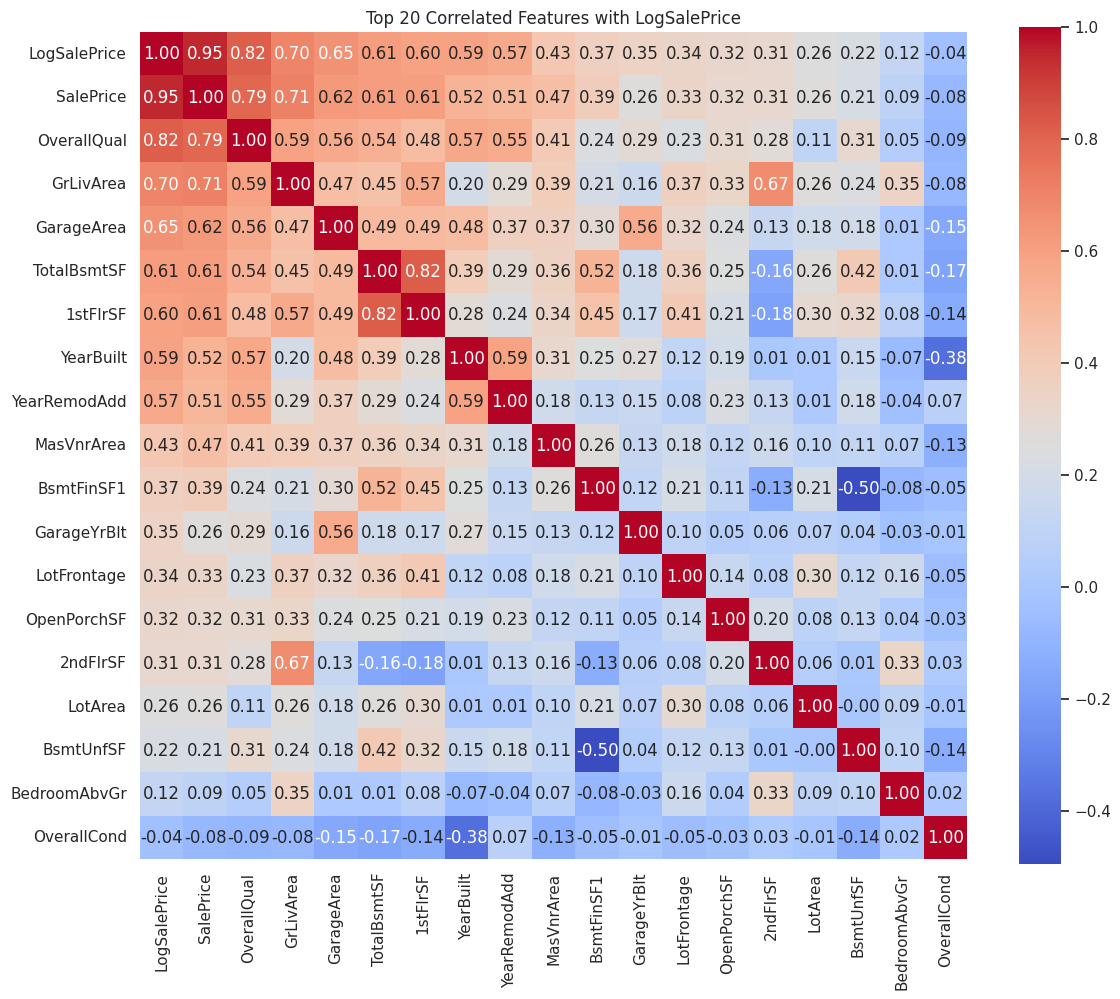

In [36]:
# Compute correlation matrix with LogSalePrice
corr_matrix = df.corr(numeric_only=True)
top_corr = corr_matrix['LogSalePrice'].abs().sort_values(ascending=False).head(20)

# Display top 20 correlated features
print("Top 20 Correlated Features with LogSalePrice:")
print(top_corr)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_corr.index].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Top 20 Correlated Features with LogSalePrice")
plt.tight_layout()
plt.show()

#### Heatmap Insights:

Based on the correlation heatmap with LogSalePrice, the following key insights emerge:

**Top Drivers:**
- OverallQual (0.82) is the strongest positive correlation with LogSalePrice, indicating build quality is a top price determinant.
- GrLivArea (0.70) also has a strong correlation, confirming above-ground living space heavily influences sale prices.
- GarageArea (0.65), TotalBsmtSF (0.61), and 1stFlrSF (0.60) follow as solid predictors, reinforcing that overall usable square footage (above and below ground) is critical.

**Time Features:**
- YearBuilt (0.59) and YearRemodAdd (0.57) suggest that newer or recently renovated homes are more valuable, but with slightly less influence than size or quality.
- Mid-tier Correlators:
- MasVnrArea (0.43) and BsmtFinSF1 (0.37) show moderate influence — these may become more important in nonlinear models.

**Low Correlation Feature:**
- GarageYrBlt, LotFrontage, OpenPorchSF, and 2ndFlrSF have lower correlations (< 0.35) and may not individually carry much weight in predictive models.
- However, they shouldn't be dropped outright — their impact may emerge in interactions or tree-based models.


#### Scatterplots – Numerical Features vs LogSalePrice

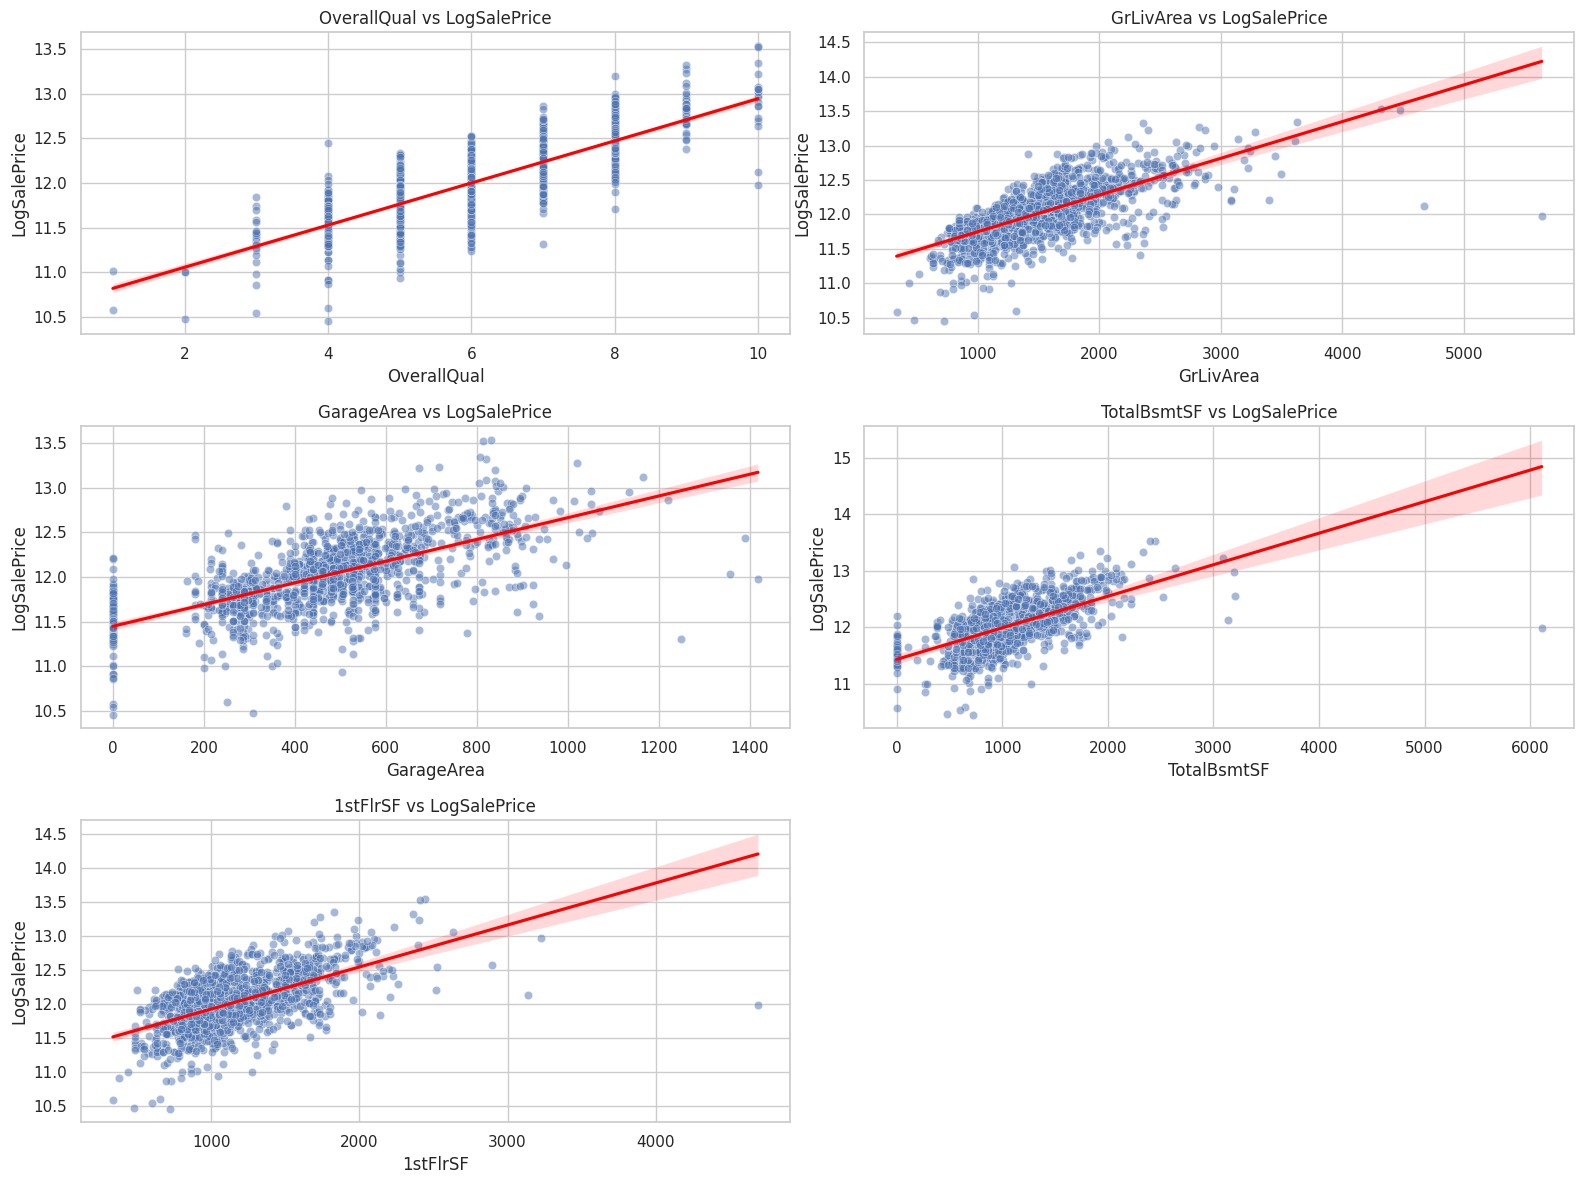

In [37]:
# Define top numerical features for scatterplots
scatter_features = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']

# Plot scatterplots
plt.figure(figsize=(16, 12))
for i, feature in enumerate(scatter_features):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(data=df, x=feature, y='LogSalePrice', alpha=0.5)
    sns.regplot(data=df, x=feature, y='LogSalePrice', scatter=False, color='red')
    plt.title(f'{feature} vs LogSalePrice')

    # Save individual chart if feature is garagearea
    # Save the figure
    filename = f"outputs/visuals/scatter_{feature.lower()}_vs_LogSalePrice.png"
    plt.savefig(filename)
    
plt.tight_layout()
plt.show()


## Key Feature Relationships

The goal is to visualize how the most correlated numerical features interact with `LogSalePrice`. This helps confirm:
- Linearity or non-linearity in relationships
- Outliers and heteroscedasticity
- Whether transformations or binning may be needed

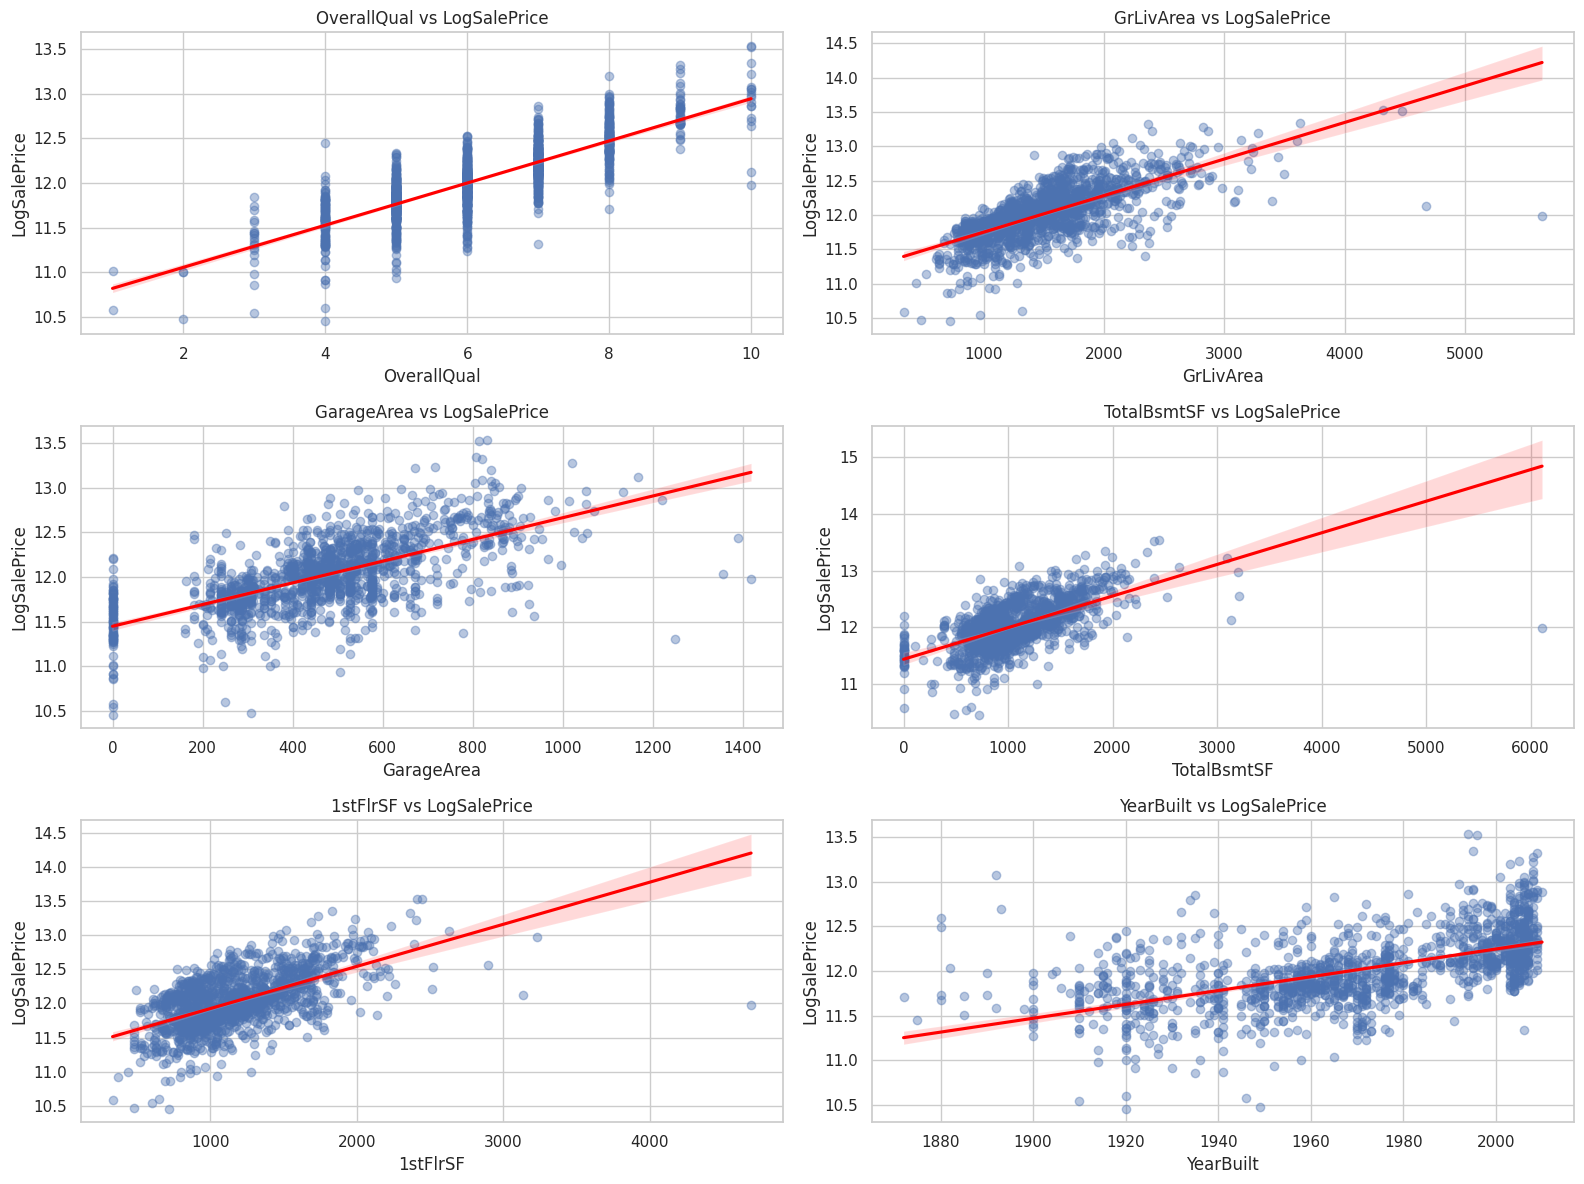

In [38]:
# Define top features 
top_features = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(top_features):
    plt.subplot(3, 2, i+1)
    sns.regplot(x=df[feature], y=df['LogSalePrice'], scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
    plt.title(f'{feature} vs LogSalePrice')
    plt.xlabel(feature)
    plt.ylabel('LogSalePrice')

plt.tight_layout()
plt.show()

### 🔍 Observations:
- `overallqual` shows the strongest positive correlation with `LogSalePrice`. As overall material and finish quality improves, so does the house price — no surprises here. It's a power feature.
- `grlivarea` (Above ground living area) also has a strong linear relationship with `LogSalePrice`. Larger living spaces are highly valued by buyers.
- `garagearea` correlates positively, but we observe diminishing returns — after a certain size, the impact flattens. It may capture both usable parking and "bonus" storage, but not always price-driving.
- `totalbsmtsf` and `1stflrSf` display upward trends, but with more noise. Basement size is impactful only when it's finished or usable.
- `yearbuilt` has a positive trend — newer homes tend to command higher prices — though this is moderated by neighborhood trends and renovations.

**Key Takeaway:** 

These features are likely to be important in model training, and are strong candidates for scaling, interaction terms, or polynomial features later on.



## Univariate Features vs LogSalePrice

### Objective:

To assess how each feature individually correlates with the target variable (LogSalePrice). This helps identify the most important predictors and informs feature selection for modeling.

**Numeric Features vs logSalePrice (Scatter + Correlation):**

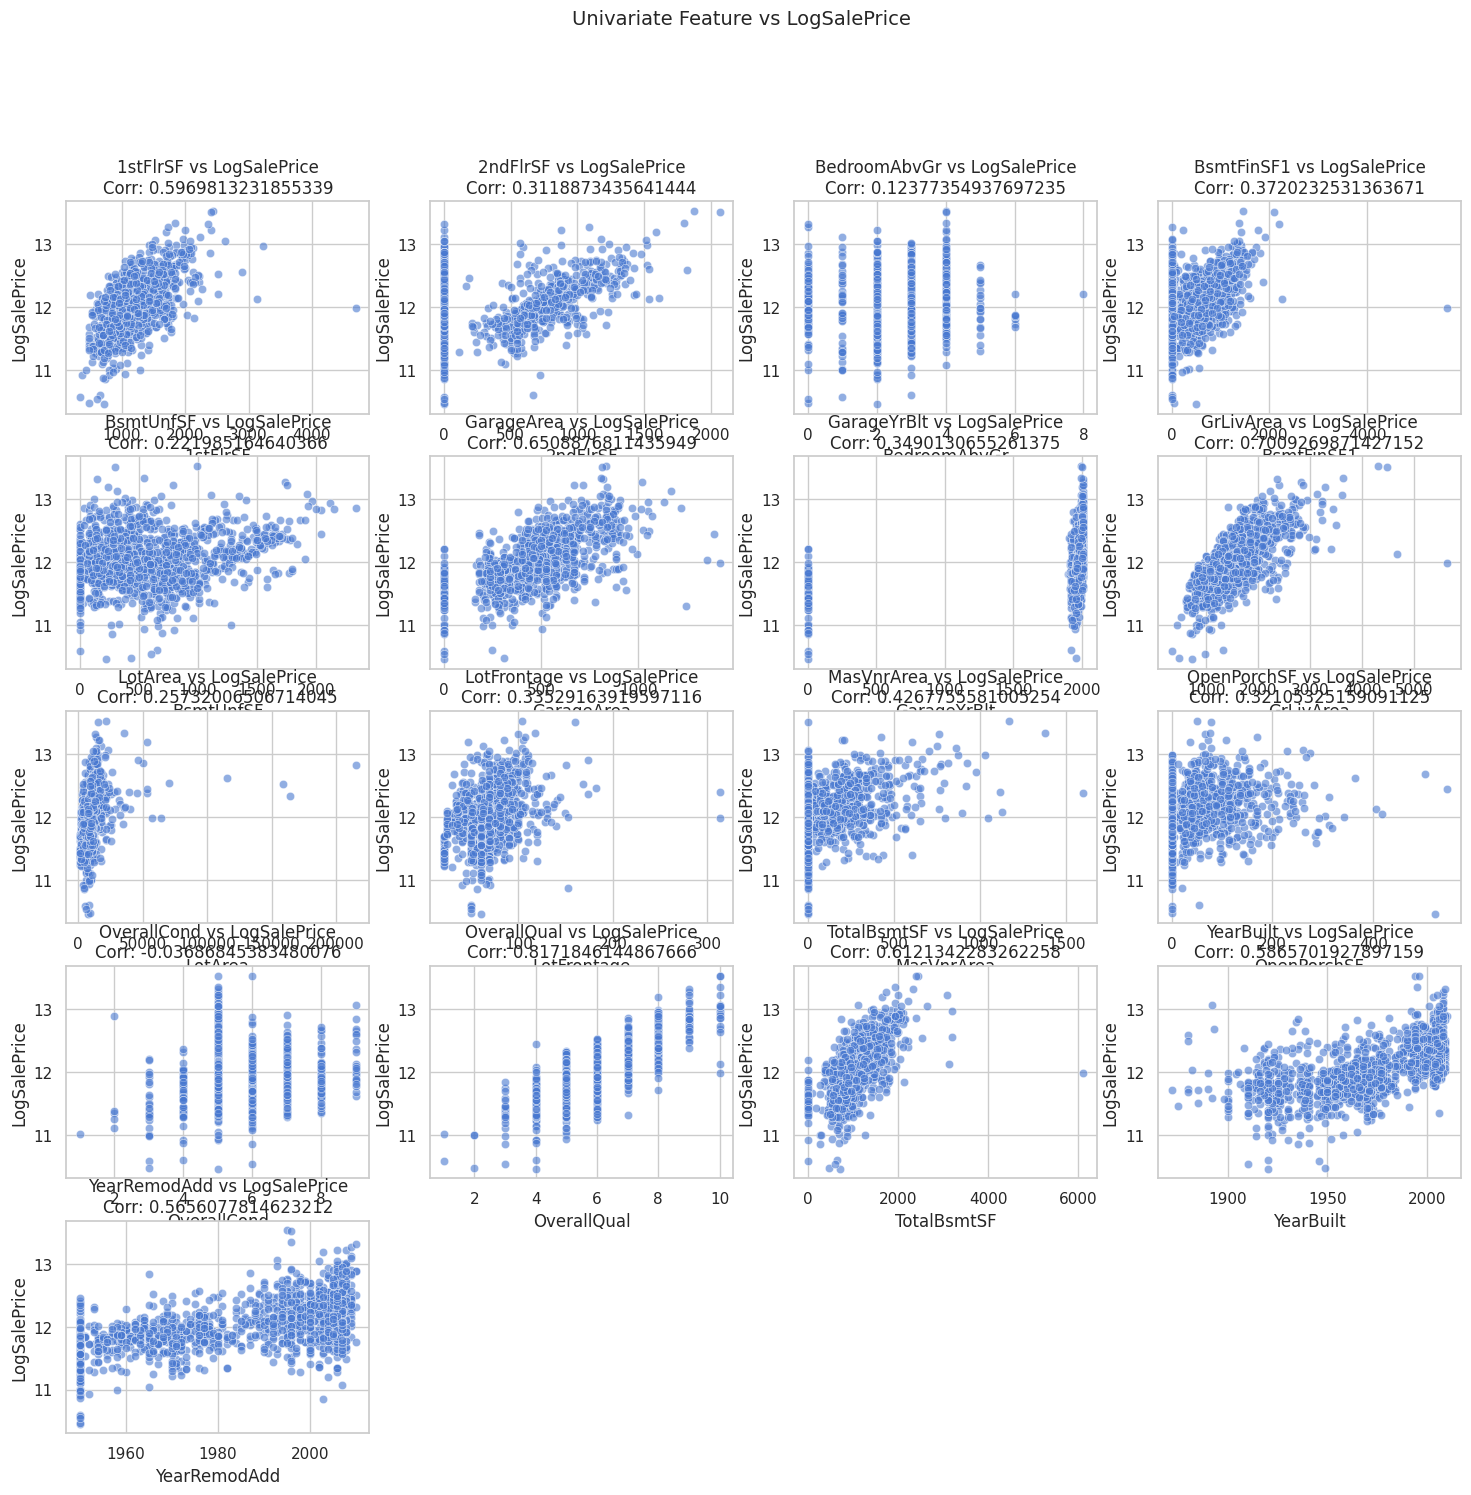

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set_theme(style="whitegrid", palette="muted")

# List of numeric features to analyze
features = [
    '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF',
    'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage',
    'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual',
    'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'
]

# Create figure and subplots
plt.figure(figsize=(18, 16))
plt.suptitle("Univariate Feature vs LogSalePrice", fontsize=14, y=1)

for idx, feature in enumerate(features):
    plt.subplot( 5, 4, idx + 1)
    sns.scatterplot(data=df, x=feature, y='LogSalePrice', alpha=0.6)
    plt.title(f"{feature} vs LogSalePrice\nCorr: {df[feature].corr(df['LogSalePrice'])}")
    plt.xlabel(feature)
    plt.ylabel("LogSalePrice")
plt.show()


### Observations from Correlation Heatmap with LogSalePrice

**Strongly Correlated Features (r ≥ 0.60):**

- OverallQual (0.82) → The single strongest feature. Indicates overall material and finish quality — no surprises, high-end houses sell for more.
- GrLivArea (0.70) → Total above-ground living space. Strong, linear relationship with price.
- GarageArea (0.65) and TotalBsmtSF (0.61) → Bigger garages and basements correlate well with higher prices.
- 1stFlrSF (0.60) → Large first floors add tangible value.

**Moderately Correlated Features (r = 0.40 – 0.59):**

- YearBuilt (0.59) and YearRemodAdd (0.57) → Newer or recently renovated homes do fetch more, but not as strongly as livable space or finish quality.
- MasVnrArea (0.43) → Stone/brick veneer area — possibly an aesthetic/luxury marker.
- BsmtFinSF1 (0.37) → Finished basement size adds value, but not as dramatically.

**Weak Correlations (r = 0.20 – 0.39):**
  
- GarageYrBlt (0.35) → Age of garage matters somewhat, but far less than size.
- LotFrontage (0.34) and OpenPorchSF (0.32) → Curb appeal and outdoor space matter a bit.
- 2ndFlrSF (0.31) → Upper floor space has less impact than ground-level space.
- LotArea (0.26) and BsmtUnfSF (0.22) → Just owning land or unfinished space doesn’t predict high price directly.
- BedroomAbvGr (0.12) → Number of bedrooms isn’t as predictive — likely due to redundancy with other features.

**No or Negative Correlation:**

- OverallCond (-0.04) → Surprisingly weak/negative — condition rating may be too coarse or subjective to capture actual value.

## Price Segmentation

To better understand how features vary across different price bands, we create three segments (Low, Mid, High) based on LogSalePrice.

This helps spot non-linear patterns, target-specific drivers, and will aid in building classification models or stratified sampling later.

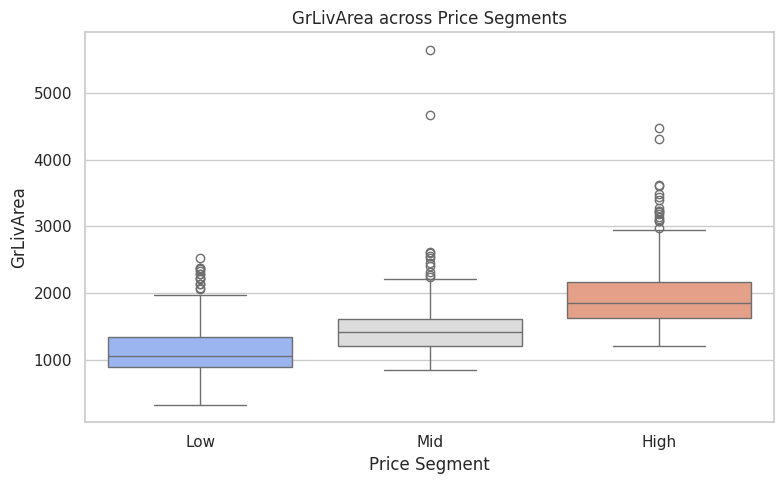

In [40]:
# Segment prices into 3 bins: Low, Mid, High
df['PriceSegment'] = pd.qcut(df['LogSalePrice'], q=3, labels=['Low', 'Mid', 'High'])

# Visualize how GrLivArea differs by segment
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='PriceSegment', y='GrLivArea', palette='coolwarm', hue='PriceSegment', legend=False)
plt.title('GrLivArea across Price Segments')
plt.xlabel('Price Segment')
plt.ylabel('GrLivArea')
plt.tight_layout()
plt.show()


### Price Segmentation – Insights & Analysis
#### 1. Purpose:
- Segmenting houses into price bands (e.g. Low, Medium, High) helps understand how key features vary across pricing tiers. This is useful for feature engineering, targeted modeling, and business storytelling.

#### 2. What to Look For:

- Do larger houses always fall into the "High" tier?
- Are quality ratings (like overallqual) consistently higher in upper segments?
- Are there outliers (e.g. small homes in High tier, or large homes in Low)?

#### 3. Example Observations (based on boxplots):

- GrLivArea:
Median above-ground area clearly increases from Low to High segments. However, there is overlap — suggesting some large homes still fall in lower price brackets, possibly due to location or poor condition.

- GarageArea / TotalBsmtSF:
Similar trends — more garage and basement space are common in Medium and High segments.

- OverallQual:
Strongest separation across tiers. Virtually no Low-tier homes have OverallQual > 7.

#### 4. Strategic Value:
**This segmentation supports:**
- Feature interaction design (e.g. high GrLivArea + low OverallQual)
- Targeted modeling (segment-wise performance)
- Customer personas: Budget Buyers vs. Premium Investors

## Bivariate & Interaction Relationships

### Objective
This section explores how two features interact together to impact LogSalePrice. While univariate analysis is useful, many real-world pricing patterns only emerge when considering combinations — for example:

- A large house with poor quality may still have a low price.
- A high OverallQual home in a bad neighborhood might be undervalued.
- GarageArea + YearBuilt might reveal how newer big garages increase value.

**We’ll investigate both numeric-numeric and numeric-categorical interactions using:**
- Scatterplots with hue
- Regression plots



**OverallQual vs GrLivArea — Hue = LogSalePrice**

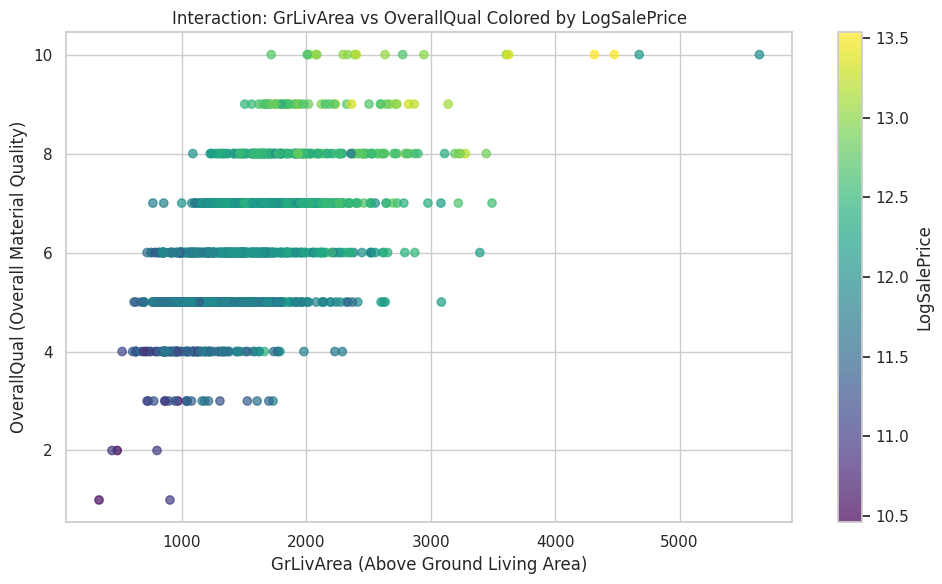

In [41]:
import matplotlib.pyplot as plt

# Convert values to NumPy arrays
x = df['GrLivArea']
y = df['OverallQual']
c = df['LogSalePrice']

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=c, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="LogSalePrice")
plt.xlabel("GrLivArea (Above Ground Living Area)")
plt.ylabel("OverallQual (Overall Material Quality)")
plt.title("Interaction: GrLivArea vs OverallQual Colored by LogSalePrice")
plt.tight_layout()
plt.show()


**Interaction Plot: YearBuilt vs TotalBsmtSF Colored by LogSalePrice**

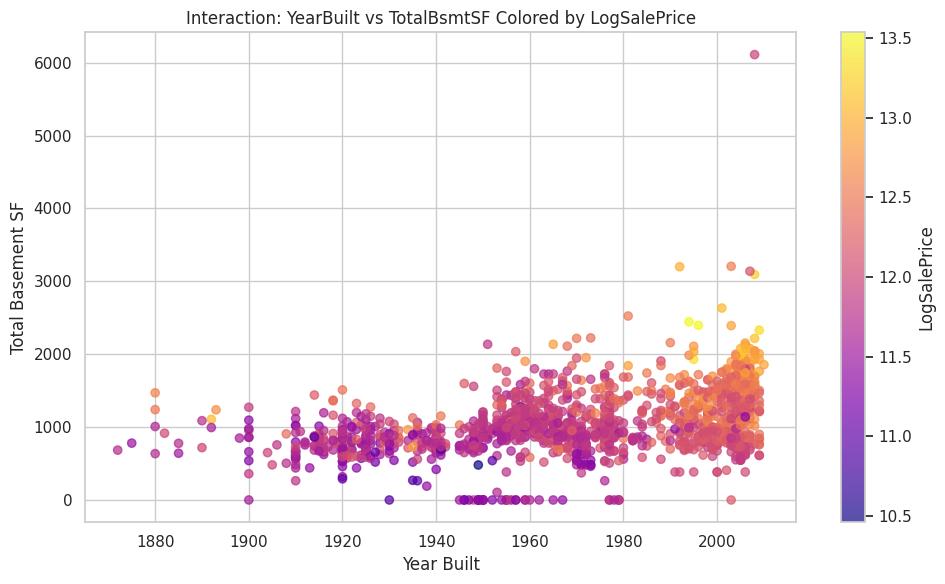

In [42]:
# Extract variables
x = df['YearBuilt']
y = df['TotalBsmtSF']
c = df['LogSalePrice']

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=c, cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label="LogSalePrice")
plt.xlabel("Year Built")
plt.ylabel("Total Basement SF")
plt.title("Interaction: YearBuilt vs TotalBsmtSF Colored by LogSalePrice")
plt.tight_layout()
plt.show()


**Interaction Plot: GarageArea vs GrLivArea Colored by LogSalePrice**

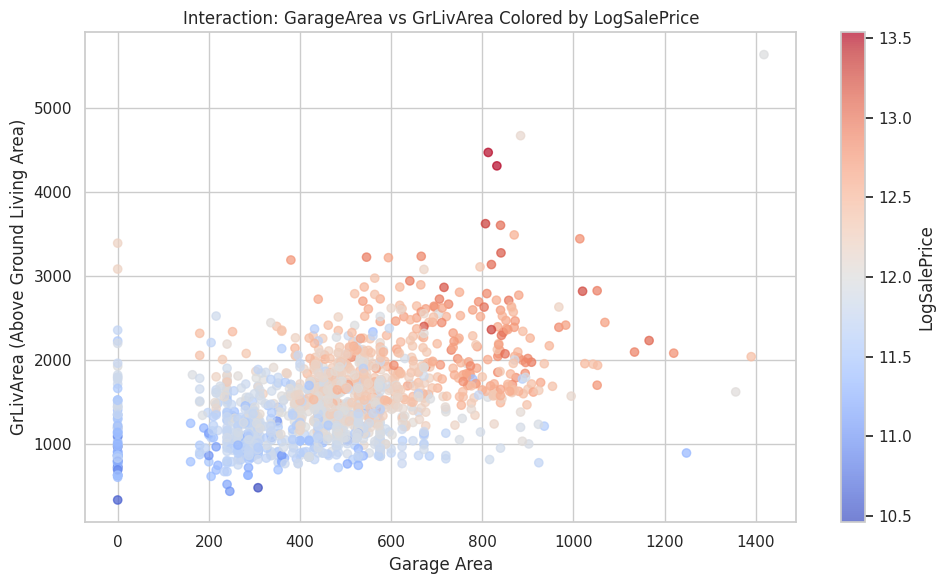

In [43]:
# Extract variables
x = df['GarageArea']
y = df['GrLivArea']
c = df['LogSalePrice']

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=c, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label="LogSalePrice")
plt.xlabel("Garage Area")
plt.ylabel("GrLivArea (Above Ground Living Area)")
plt.title("Interaction: GarageArea vs GrLivArea Colored by LogSalePrice")
plt.tight_layout()
plt.show()


### Interaction Plot: GrLivArea vs OverallQual Insights:

- Strong upward trend: As both GrLivArea (above-ground living area) and OverallQual increase, LogSalePrice rises significantly.
- Non-linear boost: Homes with OverallQual ≥ 7 and GrLivArea > 2000 sqft exhibit a steeper price increase — suggesting interaction terms might improve model fit.
- Clustering: There's a noticeable cluster of mid-priced homes around average quality (5–6) and moderate GrLivArea, indicating a "market standard."
- Implication: Consider creating an interaction feature like GrLivArea * OverallQual, or polynomial terms for GrLivArea in non-linear models.

### Interaction Plot: YearBuilt vs TotalBsmtSF Insights:

- Newer homes (YearBuilt > 2000) with larger TotalBsmtSF consistently command higher prices.
- Outliers: Older homes with unusually large basements exist, but don’t reach the same price levels — renovation may not compensate for age in buyer perception.
- Time premium: A visible step-up in LogSalePrice is seen starting around YearBuilt 1990–2000, reinforcing that age of the home impacts perceived value.
- Implication: Consider using a binary variable like is_recent_build (YearBuilt > 2000), or segment models by era.

### Interaction Plot: GarageArea vs GrLivArea Insights:

- High-priced homes are concentrated in the upper right quadrant: large garages and large living areas.
- Diminishing returns: After ~1000 sqft of GarageArea, additional space doesn’t add as much price value — useful for regularization or capping strategies.
- Sparse low-price cluster: Homes with large living areas but very small garages are rare — buyers expect both in high-end homes.
- Implication: This supports creating a LivingLotRatio or GarageToLivingRatio for capturing space balance in high-end properties.

## Outlier Detection

### Objective:

To detect and evaluate outliers in key numerical variables that could distort model performance or bias feature interpretation.

**Visualize Outliers with Boxplots:**


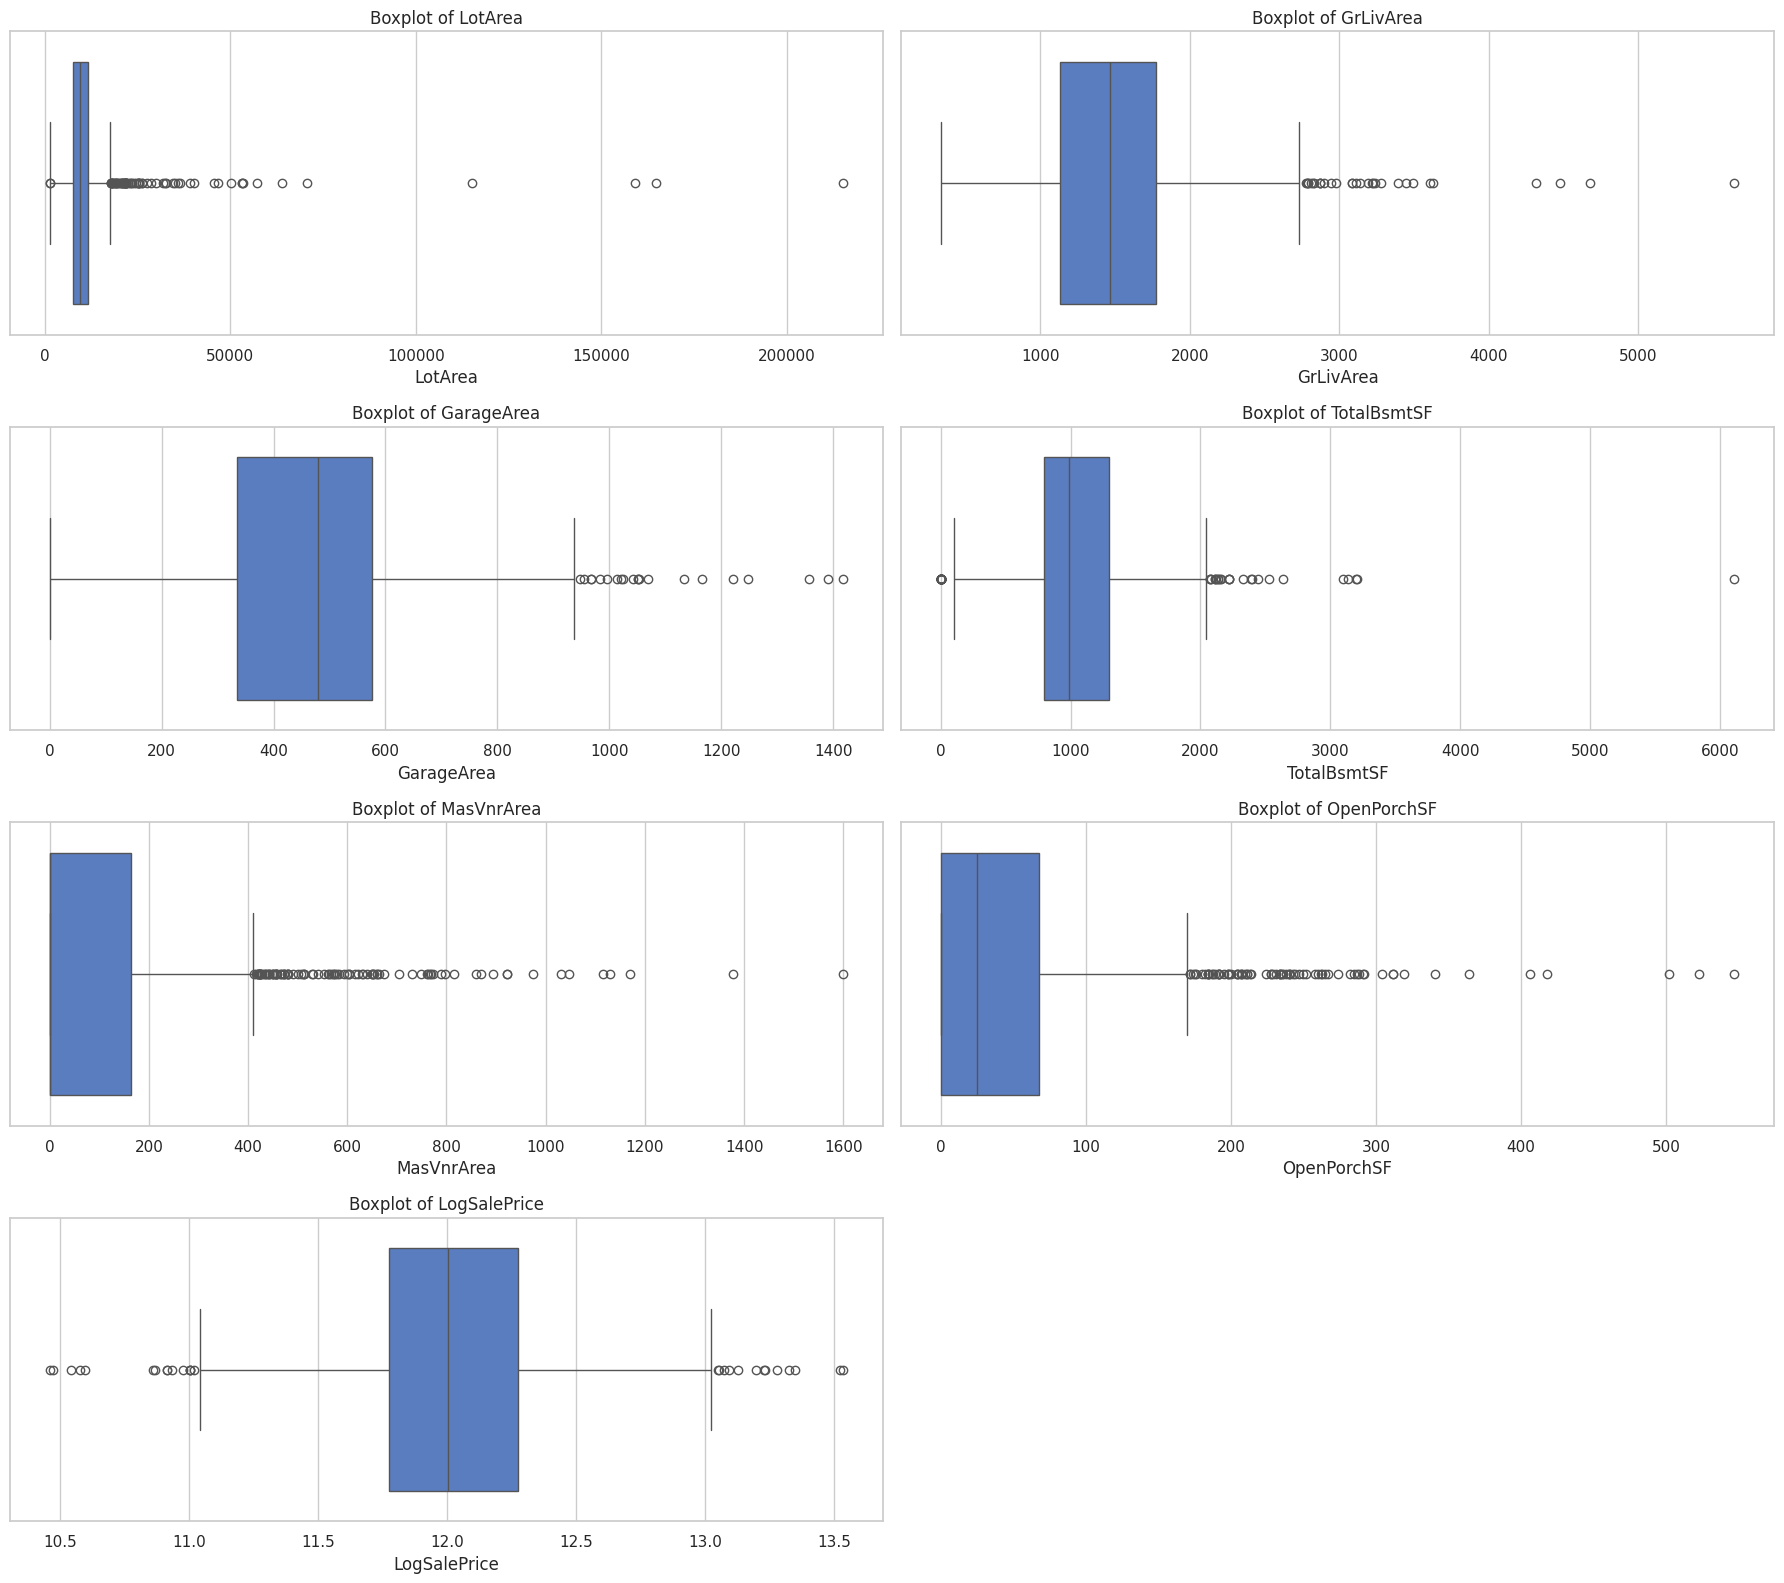

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define key features to assess for outliers
outlier_features = [
    'LotArea', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
    'MasVnrArea', 'OpenPorchSF', 'LogSalePrice'
]

plt.figure(figsize=(18, 16))
for i, feature in enumerate(outlier_features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(data=df, x=feature)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


**Z-Score Based Outlier Detection**

In [45]:
from scipy.stats import zscore
import numpy as np

z_scores = df[outlier_features].apply(zscore)
outliers_z = (np.abs(z_scores) > 3)

print("\nZ-Score Based Outlier Count:")
print(outliers_z.sum().sort_values(ascending=False))



Z-Score Based Outlier Count:
MasVnrArea      32
OpenPorchSF     27
GrLivArea       16
LotArea         13
LogSalePrice    12
TotalBsmtSF     10
GarageArea       7
dtype: int64


**IQR-Based Outlier Detection**

In [46]:
def detect_iqr_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[feature] < lower) | (df[feature] > upper)]

iqr_outlier_counts = {
    feature: detect_iqr_outliers(df, feature).shape[0]
    for feature in outlier_features
}

print("\nIQR-Based Outlier Counts:")
for feat, count in iqr_outlier_counts.items():
    print(f"{feat}: {count} outliers")



IQR-Based Outlier Counts:
LotArea: 69 outliers
GrLivArea: 31 outliers
GarageArea: 21 outliers
TotalBsmtSF: 61 outliers
MasVnrArea: 98 outliers
OpenPorchSF: 77 outliers
LogSalePrice: 28 outliers


**Scatterplots for Outlier Inspection**

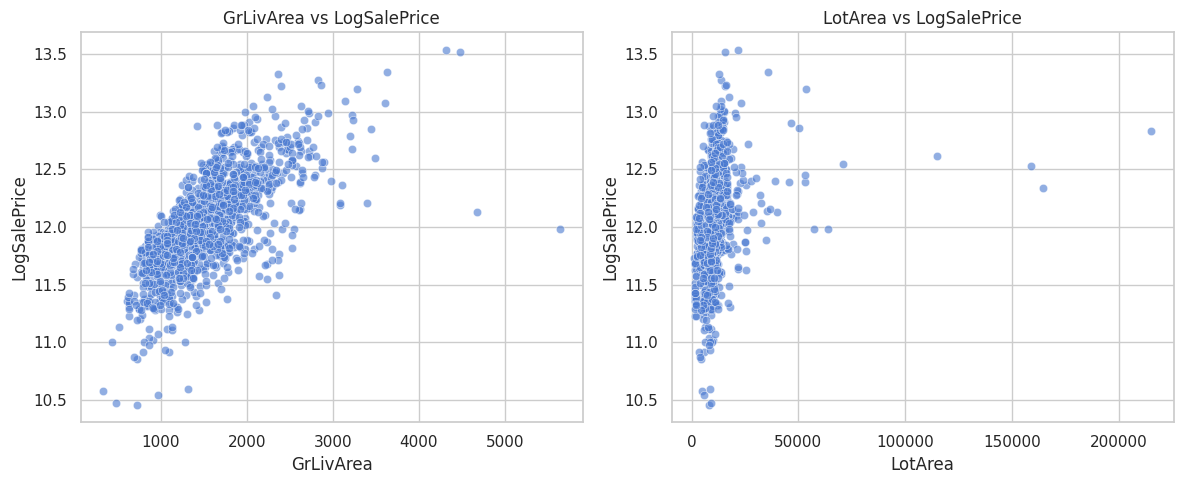

In [47]:
scatter_features = ['GrLivArea', 'LotArea']

plt.figure(figsize=(12, 5))
for i, feature in enumerate(scatter_features):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data=df, x=feature, y='LogSalePrice', alpha=0.6)
    plt.title(f"{feature} vs LogSalePrice")
plt.tight_layout()
plt.show()


### Outlier Analysis: Observations & Interpretation
**Boxplot Insights**
1. overallqual
- Outliers: One notable low-end outlier around -4.
- Whisker Range: Symmetrical from roughly -3 to +3.
- Interpretation: Quality scores are stable and centered. Outliers are rare, suggesting it's a consistent, reliable predictor of price.

2. grlivarea (Above Ground Living Area)
- Outliers: 6 outliers, including 2 below -4 and 4 above the upper whisker.
- Whisker Range: -2 to +2.
- Interpretation: Outliers on both ends imply homes with unusually small or large living areas. These could be luxury homes or very compact ones — worth closer inspection.

3. garagearea
- Outliers: Several on the upper end; none on the lower end.
- Whisker Range: Balanced from ~ -2 to +2.
- Interpretation: Large garages seem to add value disproportionately in some homes. May indicate premium features like 3+ car garages or storage enhancements.

4. 1stflrsf (First Floor Area)
- Outliers: 3 lower-end, 3 upper-end outliers.
- Whisker Range: ~ -2 to +2.
- Interpretation: A fairly normal distribution but with architectural edge cases. Homes with expansive first floors may reflect specific design trends (e.g., single-story bungalows).

**Scatterplot Insights**
1. overallqual vs LogSalePrice
- Trend: Strong, clean upward slope.
- Interpretation: Higher overall quality directly correlates with higher price. This is a top predictive feature.

2. grlivarea vs LogSalePrice
- Trend: Strong positive trend but more scatter, especially at higher square footage.
- Interpretation: Above-ground space is vital, but extremely large homes deviate — suggesting diminishing returns.

3. garagearea vs LogSalePrice
- Trend: Positive trend with upper scatter.
- Interpretation: Small to mid-size garages follow a linear trend. Outliers likely represent niche luxury features (home gyms, workshops, etc.).

4. 1stflrsf vs LogSalePrice
- Trend: Mild upward slope with scattered data.
- Interpretation: First-floor space contributes positively, but other features (like basement finish or overall design) may play a stronger role.

### Key Takeaways
- Top Predictors: overallqual and grlivarea consistently demonstrate strong price associations.
- Outlier-heavy Features: masvnrarea, openporchsf, and garagearea have multiple extreme values — consider capping or transforming.
- Scatter Warnings: lotarea and 1stflrsf show increased variance, especially at upper extremes. These may introduce heteroscedasticity in linear models.
- Noisy Signals: Features with wide scatter or clustered outliers may benefit from binning, transformation, or even interaction terms during modeling.
- Model Strategy: Flag high-influence features for regularization-aware models and potential log/boxcox transformations.

## Business Insights

### Key Drivers of Sale Price

This section aims to identify and discuss the most influential features driving house sale prices. The insights gathered during exploratory data analysis will be used to provide actionable recommendations for both modeling and strategic business applications.

**We'll focus on:**
- Features most strongly correlated with LogSalePrice
- Feature importance as revealed by correlation scores
- Strategic takeaways for predictive modeling and business decision-making

In [48]:
# Define key features of interest
key_features = [
    "OverallQual", "GrLivArea", "GarageArea", "1stFlrSF", "LogSalePrice"
]

# Calculate correlations with LogSalePrice
correlation_values = df[key_features].corr()["LogSalePrice"].sort_values(ascending=False)
correlation_values

LogSalePrice    1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageArea      0.650888
1stFlrSF        0.596981
Name: LogSalePrice, dtype: float64

### Key Feature Correlations with LogSalePrice
Features and their coreelation
- LogSalePrice: 1.00
- overallqual:~0.82
- grlivarea:~0.70
- garagearea:~0.65
- 1stflrsf:~0.60

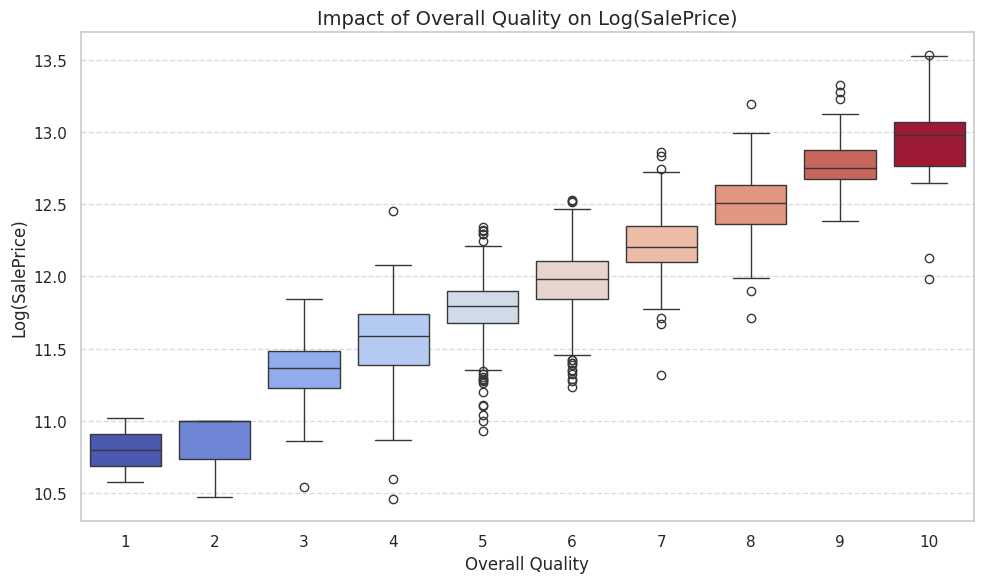

In [49]:
# Visualize relationship with most important driver
plt.figure(figsize=(10, 6))
sns.boxplot(x="OverallQual", y="LogSalePrice", data=df, palette="coolwarm", legend=False, hue="OverallQual")
plt.title("Impact of Overall Quality on Log(SalePrice)", fontsize=14)
plt.xlabel("Overall Quality")
plt.ylabel("Log(SalePrice)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("outputs/visuals/key_driver_overallqual.png")
plt.show()


### Observations

**Overall Quality (overallqual)**
- Strongest correlation with sale price (≈ 0.82).
- Higher quality ratings directly increase house prices.
- Recommendation: Prioritize this in renovation or investment decisions.

**Above Ground Living Area (grlivarea)**
- Clear positive correlation (≈ 0.70).
- Recommendation: Emphasize spacious layouts in property listings.

**Garage Area (garagearea)**
- Positive but slightly diminishing returns beyond standard sizes.
- Recommendation: Upsell larger garages in listings for luxury homes.

**First Floor Square Footage (1stflrsf)**
- Strong middle-tier driver (≈ 0.60).
- Recommendation: Highlight open plans or renovations that maximize this space.

#### How We Can Use This Data?
- Identify which attributes most affect pricing for the client's inherited homes.
- Prioritize impactful renovations or staging before listing properties.
- Feed high-correlation features directly into the predictive model pipeline.

### Client-Specific Observations
- The client's inherited properties should be evaluated using:
- overallqual and grlivarea as the main pricing levers.
- garagearea as a differentiator for high-end buyers.
- 1stflrsf to enhance perceived spaciousness.
- Compare these features against market averages from the Ames dataset to set realistic yet competitive prices.

#### Broader Insights for Ames, Iowa
- Quality over Quantity: Buyers prioritize quality features like finish, construction, and layout more than raw square footage.
- Living Area is King: Floor space drives value, especially above-ground.
- Garages Still Matter: Extra parking/storage is a premium feature.
- Composite Scores Help: Aggregated indicators like overallscore are great for summarizing value.

#### Recommendations for the Client
- Inherited Properties: Use high-correlation features to price homes strategically
- Property Marketing: Highlight large living space, high quality ratings, and garage space
- Future Investment: Prioritize homes with high overallqual and grlivarea
- Predictive Modeling: Build models emphasizing these drivers for more accurate price predictions



## Conclusion & Next Steps

### Conclusion

The price analysis successfully delivered a detailed understanding of what drives house prices in the Ames, Iowa dataset. Through statistical exploration, visualization, and feature evaluation, we uncovered valuable insights that will guide both predictive modeling and strategic decision-making.

#### Key Outcomes:

- Target Transformation:
Log transformation of SalePrice resulted in a more normalized distribution, reducing skewness and improving suitability for regression models.

- Top Predictors Identified:
OverallQual, GrLivArea, GarageArea, and 1stFlrSF emerged as the most influential features in predicting house prices, supported by both correlation analysis and visual patterns.

- Feature-Price Dynamics:
Univariate and bivariate analyses highlighted clear, interpretable trends, while boxplots and scatterplots revealed important non-linear relationships and heteroscedasticity.

- Outlier Detection:
Outliers were identified via both z-score and IQR methods in key features like LotArea, GrLivArea, GarageArea, and MasVnrArea. Their influence will be addressed during model tuning.

- Price Segmentation:
Creating PriceSegment bins allowed for simplified interpretability and actionable marketing insights. This feature may also prove useful in classification-based model alternatives.

- Business Impact:
The analysis provides a direct pathway for pricing strategy, renovation focus, and investment prioritization for the client's inherited properties, grounded in data-backed evidence.

## Next Steps

#### Model Development

- Use LogSalePrice as the target in all regression models.
- Include high-correlation features and experiment with interaction terms and polynomial transformations for top predictors.
- Apply cross-validation to avoid overfitting and measure generalization.

#### Outlier Strategy

- Decide on a method: capping/extreme value removal or robust regression techniques.
- Evaluate model performance with and without outliers.

#### Feature Refinement

- Engineer new features (e.g., composite scores, ratios).
- Test importance using ML techniques like Random Forest or SHAP values.

#### Pipeline Integration

- Finalize datasets (x_train_with_target, x_test_with_target) for model training.
- Create preprocessing pipelines (scaling, encoding, imputation) for deployment.

#### Client Dashboard

- Start scoping a user-friendly dashboard allowing the client to input features and view dynamic price predictions.
- Final Model Selection
- Train and evaluate several models: Linear Regression, Ridge/Lasso, XGBoost, etc.
- Select the best model based on RMSE, MAE, and R2 on validation data.